## Énoncé
Data Scientist dans une très jeune start-up de l'AgriTech, nommée "Fruits!", qui cherche à proposer des solutions innovantes pour la récolte des fruits.
La start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.
## Mission
Notre mission consiste à développer dans un environnement Big Data une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension.

### Chargement des librairies

In [2]:
# spark initialisation
import findspark
findspark.init("/home/ubuntu/spark-3.3.0-bin-hadoop3")
import pyspark
import pyarrow
# context & session
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
# usefull packages
import pandas as pd
import numpy as np
import random
import time
import os
# deal with image
from PIL import Image
# data handling
from pyspark.sql.functions import element_at, split, col,size
from pyspark.sql.functions import pandas_udf, PandasUDFType, udf
from pyspark.sql.types import *
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window
from typing import Iterator
# ml tasks
from pyspark.ml.image import ImageSchema
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
# transform
from pyspark.ml.linalg import Vectors, VectorUDT
# core featurizer
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

### Spark configuration

Définissons une configuration pour permettre à spark de lire les images depuis S3:

 Tout d'abord, définissons une fonction pour charger les clés d'accès à AWS:

In [3]:
def load_aws_key():
    '''Function that loads ID/KEY of AWS in environment variables 
    from keys.txt file'''
    with open('keys.txt','r') as f:
        msg = f.read()
    ID = str(msg).split('\n')[0]
    KEY = msg.split('\n')[1]
    os.environ["AWS_ACCESS_KEY_ID"]=ID
    os.environ["AWS_SECRET_ACCESS_KEY"]=KEY
    return ID, KEY

Récuperons les clès d'accès à AWS:

In [4]:
AWS_ACCESS_KEY_ID,AWS_SECRET_ACCESS_KEY=load_aws_key()

Configurons spark pour la lecture des fichiers dans AWS:

In [5]:
conf=SparkConf()
conf.set('spark.jars.packages','org.apache.hadoop:hadoop-aws:3.3.2')
conf.set('spark.executor.extraJavaOptions','-Dcom.amazonaws.services.s3.enableV4=true')
conf.set('spark.driver.extraJavaOptions','-Dcom.amazonaws.services.s3.enableV4=true')
conf.set("spark.hadoop.fs.s3a.aws.access.key", AWS_ACCESS_KEY_ID)
conf.set("spark.hadoop.fs.s3a.aws.secret.key", AWS_SECRET_ACCESS_KEY)
conf.set('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')
conf.set("fs.s3a.endpoint", "s3-eu-west-1.amazonaws.com")

### Spark session

Initialisons notre spark session:

In [7]:
spark = SparkSession.builder.config(conf=conf).appName('Projet8').getOrCreate()
spark._sc.setSystemProperty("com.amazonaws.services.s3.enableV4", "true")

Visualisons la session Spark initialisé:

In [8]:
spark

### AWS S3 resources

Obtenons l'accès aux ressources de S3 via boto3:

In [9]:
import boto3
s3 = boto3.resource('s3')

Définissons une fonction pour afficher les buckets presents s3:

In [10]:
def list_buckets(ressource):
    """Print all existing buckets names"""
    for bucket in ressource.buckets.all():
        print(bucket.name)

Affichons les buckets présents dans S3:

In [11]:
list_buckets(s3)

elasticbeanstalk-us-east-2-017246177437
olivierfruitsdataset


## Pre-processing des images

### Chargement  des catégories de fruits

Définissons des fonctions pour lister de tous repertoires contenant les images:

In [12]:
def list_categories(bucket, prefix):
    """Function to create a list of all directories containing the image."""
    client=boto3.client('s3')
    sub_folders =[]
    result=client.list_objects(Bucket=bucket ,Prefix=prefix, Delimiter='/')
    for o in result.get('CommonPrefixes'):
        sub_folders.append(list(o.get('Prefix').split(" ")))
    print("Number of images's category is:", len(sub_folders))
    return sub_folders

Affichons les repertoires contenant les images:

In [13]:
bucket='olivierfruitsdataset'
prefix="dataset_images/"
list_cat = list_categories(bucket, prefix)
list_cat

Number of images's category is: 11


[['dataset_images/Apricot/'],
 ['dataset_images/Avocado/'],
 ['dataset_images/Clementine/'],
 ['dataset_images/Cocos/'],
 ['dataset_images/Corn/'],
 ['dataset_images/Kaki/'],
 ['dataset_images/Pear/'],
 ['dataset_images/Pepino/'],
 ['dataset_images/Physalis/'],
 ['dataset_images/Redcurrant/'],
 ['dataset_images/Watermelon/']]

#### Choix  aléatoire d'une catégorie de fruits

Afin de tester notre architecture,choissions de maniére aléatoire une catégorie de fruits:

In [21]:
fruit_category = random.choice(list_cat)[0]
fruit_category

'dataset_images/Clementine/'

### Chargement des images

Définissons une fonction pour lire les images de la catégorie choisie depuis S3 et renvoyer un spark dataframe des images en comptant le nombre d'images contenu dans le fichier et afficher un aperçu du spark dataframe:

In [22]:
def load_image(path_image):
    """function that reads the images in a given directory and returns 
    a spark dataframe of the images then print operation's time and
    the number of images,an overview of dataframe."""
    start = time.perf_counter()
    df_img = spark.read.format('image').load(path_image, inferschema=True)
    stop = time.perf_counter()
    print(f'Data load with spark.read, elapsed time: {stop - start:0.2f}s')
    print('Number of images in this fruits categories:', df_img.count())
    print('An overview of the dataframe:')
    df_img = df_img.withColumnRenamed("image", "path_image")
    df_img.show(5)
    print("Display dataframe schema ")
    df_img.printSchema()
    return df_img

Définissons le chemin S3 des images de la catégorie choisie:

In [23]:
path_image = "s3a://olivierfruitsdataset/" + fruit_category
path_image

's3a://olivierfruitsdataset/dataset_images/Clementine/'

 Définissons le  spark dataframe des images:

In [65]:
df_img = load_image(path_image)

Data load with spark.read, elapsed time: 1.15s
Number of images in this fruits categories: 490
An overview of the dataframe:


+--------------------+
|          path_image|
+--------------------+
|{s3a://olivierfru...|
|{s3a://olivierfru...|
|{s3a://olivierfru...|
|{s3a://olivierfru...|
|{s3a://olivierfru...|
+--------------------+
only showing top 5 rows

Display dataframe schema 
root
 |-- path_image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



Un aperçu d'une image:

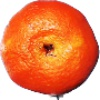

In [66]:
ImageArray_first = ImageSchema.toNDArray(df_img.first()['path_image'])[:, :, ::-1]
Image.fromarray(ImageArray_first)

### Extraction du label des images

Définissons une fonction pour extraire la categorie des images:

In [67]:
def label_extraction( df):
    """function to extract the category of images"""
    df = df.withColumn('label',element_at(split(df['path_image.origin'], "/"), -2))
    print('An overview of the dataframe:')
    df.show(5)
    return df
    

Extrayons le label des fruits et créons une feature label dans le spark dataframe :

In [68]:
df_img = label_extraction(df_img)

An overview of the dataframe:


+--------------------+----------+
|          path_image|     label|
+--------------------+----------+
|{s3a://olivierfru...|Clementine|
|{s3a://olivierfru...|Clementine|
|{s3a://olivierfru...|Clementine|
|{s3a://olivierfru...|Clementine|
|{s3a://olivierfru...|Clementine|
+--------------------+----------+
only showing top 5 rows



### Matrice de pixels des images

Définissons des fonctions pour créer les matrices de pixels des images:

In [72]:
def toNDArray(row):
    '''Function to transform image in pixel matrix.'''
    rowDict = row.asDict()
    FlatArray = ImageSchema.toNDArray(rowDict.get('path_image'))[:, :, ::-1].ravel().tolist()
    rowDict['FlatArray'] = FlatArray
    return rowDict

def dafaframeWithArray(df):
    '''Function to add image's pixel matrix to the spark dataframe. '''
    # Back to the root RDD format 
    df_imgRDD = df.rdd.map(toNDArray) 
    # update schema
    inputSchema = df.schema
    arraySchema = inputSchema.add('FlatArray', ArrayType(IntegerType()))
    # Transform back into spark DataFrame
    df = spark.createDataFrame(df_imgRDD, arraySchema)
    return df

Définissons les matrices de pixels des images:

In [73]:
df_img = dafaframeWithArray(df_img)

Un aperçu du dataframe:

In [76]:
df_img.show(5)

+--------------------+----------+--------------------+
|          path_image|     label|           FlatArray|
+--------------------+----------+--------------------+
|{s3a://olivierfru...|Clementine|[255, 255, 251, 2...|
|{s3a://olivierfru...|Clementine|[252, 255, 255, 2...|
|{s3a://olivierfru...|Clementine|[254, 254, 255, 2...|
|{s3a://olivierfru...|Clementine|[255, 255, 251, 2...|
|{s3a://olivierfru...|Clementine|[255, 255, 251, 2...|
+--------------------+----------+--------------------+
only showing top 5 rows



### Creation des features des images via CNN Transfer Learning

Pour extraire les features des images via le transfer learning, nous utilisons le model pre-entrainé VGG16 auquel nous éliminons la derniére couche relative à la classification des images:

In [57]:
vgg16 = VGG16(
    include_top=False,
    weights=None,
    pooling='max',
    input_shape=(100, 100, 3))

Vérifions que la dernière couche a été bien retirée:

In [58]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

Définissons une fonction d'extraction des features des images de la ctégorie choisie via le model VGG16:

In [59]:
def Featurizer(category,bucket):
    """Function to load the images of the chosen category
    and extraction of features from images via the pre-trained model VGG16"""
    start = time.perf_counter()
    feat = []
    for file in bucket.objects.filter(Prefix=category):
        #load image
        obj = bucket.Object(file.key)
        label = file.key.split('/')[-2]
        response = obj.get()
        file_stream = response['Body']
        img = Image.open(file_stream)
        # convert image to flatten array
        flat_array = np.array(img).ravel().tolist()
        tensor = np.array(flat_array).reshape(1, 100, 100, 3).astype(np.uint8)
        #  vgg 16 preprocess input
        prep_tensor = preprocess_input(tensor)
        # vgg16 extraction features
        features = vgg16.predict(prep_tensor).ravel().tolist()
        # Store file key, flat array and features
        feat.append((features))
    stop = time.perf_counter()
    print(f'process, elapsed time: {stop - start:0.2f}s')
    return feat

Extrayons les features des images:

In [77]:
fruits_bucket = s3.Bucket('olivierfruitsdataset')
features = Featurizer(fruit_category,fruits_bucket)

process, elapsed time: 105.03s


Créons une colonne relative au features extraites via VGG16 dans notre dataframe initiale:

In [78]:
df_2 = spark.createDataFrame([(l,) for l in features], ['vgg16_features'])
df_1 = df_img.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
df_2 = df_2.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
df_img = df_1.join(df_2, df_1.row_idx == df_2.row_idx).drop("row_idx")
df_img.show(5)

+--------------------+----------+--------------------+--------------------+
|          path_image|     label|           FlatArray|      vgg16_features|
+--------------------+----------+--------------------+--------------------+
|{s3a://olivierfru...|Clementine|[255, 255, 251, 2...|[0.21111831068992...|
|{s3a://olivierfru...|Clementine|[252, 255, 255, 2...|[0.20654268562793...|
|{s3a://olivierfru...|Clementine|[254, 254, 255, 2...|[0.20929270982742...|
|{s3a://olivierfru...|Clementine|[255, 255, 251, 2...|[0.20046141743659...|
|{s3a://olivierfru...|Clementine|[255, 255, 251, 2...|[0.20970527827739...|
+--------------------+----------+--------------------+--------------------+
only showing top 5 rows



### Reduction de la dimension via PCA

Nous allons effectuer une réduction PCA pour réduire la dimension des features extraites:

Tout dabord, transformons array en vecteurs utilisables pour la la fonction de réduction PCA: 

In [79]:
array_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
df_img = df_img.withColumn('vgg16_vectors', array_to_vector_udf('vgg16_features'))
df_img.show(5, True)

+--------------------+----------+--------------------+--------------------+--------------------+
|          path_image|     label|           FlatArray|      vgg16_features|       vgg16_vectors|
+--------------------+----------+--------------------+--------------------+--------------------+
|{s3a://olivierfru...|Clementine|[255, 255, 251, 2...|[0.21111831068992...|[0.21111831068992...|
|{s3a://olivierfru...|Clementine|[252, 255, 255, 2...|[0.20654268562793...|[0.20654268562793...|
|{s3a://olivierfru...|Clementine|[254, 254, 255, 2...|[0.20929270982742...|[0.20929270982742...|
|{s3a://olivierfru...|Clementine|[255, 255, 251, 2...|[0.20046141743659...|[0.20046141743659...|
|{s3a://olivierfru...|Clementine|[255, 255, 251, 2...|[0.20970527827739...|[0.20970527827739...|
+--------------------+----------+--------------------+--------------------+--------------------+
only showing top 5 rows



Effectuons une réduction PCA pour reduire la  dimension, tout en choisissant un k assez grand pour determiner un nombre adéquant de composantes principales:

In [80]:
start = time.perf_counter()
pca = PCA(k=20, inputCol='vgg16_vectors', outputCol='pca_vectors')
model = pca.fit(df_img)
stop = time.perf_counter()
print(f'pca - fit best k nb, elapsed time: {stop - start:0.2f}s')

pca - fit best k nb, elapsed time: 89.18s


Appliquons la réduction PCA:

In [81]:
start = time.perf_counter()
df_img = model.transform(df_img)
stop = time.perf_counter()
print(f'pca - application, elapsed time: {stop - start:0.2f}s')

pca - application, elapsed time: 0.39s


Un aperçu du nouveau dataframe:

In [82]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
df_img.limit(5)

path_image,label,FlatArray,vgg16_features,vgg16_vectors,pca_vectors
{s3a://olivierfru...,Clementine,"[255, 255, 251, 2...",[0.21111831068992...,[0.21111831068992...,[6.35642841952407...
{s3a://olivierfru...,Clementine,"[252, 255, 255, 2...",[0.20654268562793...,[0.20654268562793...,[6.38583474133162...
{s3a://olivierfru...,Clementine,"[254, 254, 255, 2...",[0.20929270982742...,[0.20929270982742...,[6.38318935983280...
{s3a://olivierfru...,Clementine,"[255, 255, 251, 2...",[0.20046141743659...,[0.20046141743659...,[6.41948457230706...
{s3a://olivierfru...,Clementine,"[255, 255, 251, 2...",[0.20970527827739...,[0.20970527827739...,[6.38689130078634...


Transformons les vecteurs PCA en array:

In [83]:
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
df_img = df_img.withColumn('pca_features', vector_to_array_udf('pca_vectors'))
df_img.limit(5)

path_image,label,FlatArray,vgg16_features,vgg16_vectors,pca_vectors,pca_features
{s3a://olivierfru...,Clementine,"[255, 255, 251, 2...",[0.21111831068992...,[0.21111831068992...,[6.35642841952407...,"[6.3564286, 1.438..."
{s3a://olivierfru...,Clementine,"[252, 255, 255, 2...",[0.20654268562793...,[0.20654268562793...,[6.38583474133162...,"[6.3858347, 1.476..."
{s3a://olivierfru...,Clementine,"[254, 254, 255, 2...",[0.20929270982742...,[0.20929270982742...,[6.38318935983280...,"[6.383189, 1.4798..."
{s3a://olivierfru...,Clementine,"[255, 255, 251, 2...",[0.20046141743659...,[0.20046141743659...,[6.41948457230706...,"[6.4194846, 1.425..."
{s3a://olivierfru...,Clementine,"[255, 255, 251, 2...",[0.20970527827739...,[0.20970527827739...,[6.38689130078634...,"[6.3868914, 1.476..."


### Sauvegarde  des resultats dans S3


Sauvegardons les fichiers crées dans S3 en utlisant les fichiers de type "parquet":

In [84]:
start = time.perf_counter()
df_img.write.format("parquet").mode('overwrite').save('s3a://olivierfruitsdataset/results_parquet')
stop = time.perf_counter()
print(f'S3 save, elapsed time: {stop - start:0.2f}s')

S3 save, elapsed time: 103.98s


### Lectures des données sauvegardées

Chargeons depuis S3 les fichiers sauvegardés:

In [85]:
start = time.perf_counter()
df_parquet = spark.read.format('parquet').load('s3a://olivierfruitsdataset/results_parquet')
stop = time.perf_counter()
print(f'S3 load, elapsed time: {stop - start:0.2f}s')

S3 load, elapsed time: 0.74s


Un aperçu du dataframe relatif aux fichiers sauvegardés:

In [86]:
df_parquet.limit(5)

path_image,label,FlatArray,vgg16_features,vgg16_vectors,pca_vectors,pca_features
{s3a://olivierfru...,Clementine,"[255, 255, 251, 2...",[0.21111831068992...,[0.21111831068992...,[6.35642841952407...,"[6.3564286, 1.438..."
{s3a://olivierfru...,Clementine,"[252, 255, 255, 2...",[0.20654268562793...,[0.20654268562793...,[6.38583474133162...,"[6.3858347, 1.476..."
{s3a://olivierfru...,Clementine,"[254, 254, 255, 2...",[0.20929270982742...,[0.20929270982742...,[6.38318935983280...,"[6.383189, 1.4798..."
{s3a://olivierfru...,Clementine,"[255, 255, 251, 2...",[0.20046141743659...,[0.20046141743659...,[6.41948457230706...,"[6.4194846, 1.425..."
{s3a://olivierfru...,Clementine,"[255, 255, 251, 2...",[0.20970527827739...,[0.20970527827739...,[6.38689130078634...,"[6.3868914, 1.476..."
